<a href="https://colab.research.google.com/github/arjygh/stocksandoptions/blob/Working_AG/TA-options.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#optional installations: 
!pip install yfinance --upgrade --no-cache-dir
# !pip3 install pandas_datareader
# !pip3 install matplotlib


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# ___library_import_statements___
import pandas as pd

# for pandas_datareader, otherwise it might have issues, sometimes there is some version mismatch
pd.core.common.is_list_like = pd.api.types.is_list_like

# make pandas to print dataframes nicely
pd.set_option('expand_frame_repr', False)  

import pandas_datareader.data as web
from pandas_datareader import data as pdr
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import ssl
from urllib import request
#dummy change


#newest yahoo API 
import yfinance as yahoo_finance

#optional 
yahoo_finance.pdr_override()

%matplotlib inline

Requirement already up-to-date: yfinance in /usr/local/lib/python3.7/dist-packages (0.1.59)


In [2]:
def computeRSI (dataframe, time_window):
    diff = dataframe.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)

    return rsi


def stochastics( dataframe, low, high, close, k, d ):
    """
    Fast stochastic calculation
    %K = (Current Close - Lowest Low)/
    (Highest High - Lowest Low) * 100
    %D = 3-day SMA of %K

    Slow stochastic calculation
    %K = %D of fast stochastic
    %D = 3-day SMA of %K

    When %K crosses above %D, buy signal 
    When the %K crosses below %D, sell signal
    """

    df = dataframe.copy()

    # Set minimum low and maximum high of the k stoch
    low_min  = df[low].rolling( window = k ).min()
    high_max = df[high].rolling( window = k ).max()

    # Fast Stochastic
    df['k_fast'] = 100 * (df[close] - low_min)/(high_max - low_min)
    df['d_fast'] = df['k_fast'].rolling(window = d).mean()

    # Slow Stochastic
    df['k_slow'] = df["d_fast"]
    df['d_slow'] = df['k_slow'].rolling(window = d).mean()
    df['d_div'] = df['d_fast'] - df['d_slow']

    return df

def MACD(dataframe,close,span1,span2,sig_span):
    df = dataframe.copy()
    exp1 = df[close].ewm(span=span1, adjust=False).mean()
    exp2 = df[close].ewm(span=span2, adjust=False).mean()
    macd = exp1-exp2
    exp3 = macd.ewm(span=sig_span, adjust=False).mean()
    df['MACD line'] = macd
    df['Sig Line'] = exp3
    df['MACD_Div'] = macd-exp3
#     plt.plot(df.Date, macd, label='MACD', color = '#EBD2BE')
#     plt.plot(df.Date, exp3, label='Signal Line', color='#E5A4CB')
#     plt.legend(loc='upper left')
#     plt.show()
    return df

def CBI_func(ticker,start_time, end_time,trade_date_delta):
    # df = dataframe.copy()
    # day30 = df['Date'].iloc[-30]
    # start_time = datetime.datetime(2017, 10, 1)
    # #end_time = datetime.datetime(2019, 1, 20)
    # end_time = datetime.datetime.now().date().isoformat() 
    # start_time = (datetime.datetime.now().date() - datetime.timedelta(days = 90)).isoformat()
    # end_time = (datetime.datetime.now().date() - datetime.timedelta(days = 30)).isoformat()
    # print("Start Date: ", start_time)
    # print("End Date: ", end_time )
    # yahoo gives only daily historical data
    connected = False
    while not connected:
        try:
            # ticker_df = pdr.get_data_yahoo(ticker, start=start_time, end=end_time)
            ticker_df = web.get_data_yahoo(ticker, start=start_time, end=end_time)
            # ticker_df = data.DataReader(ticker, 'google',start=start_time, end=end_time)
            connected = True
            # print('connected to yahoo')
        except Exception as e:
            print("Ticker: ", ticker,"  >>  Error: " + str(e))
            # time.sleep( 5 )
            continue 

    # use numerical integer index instead of date    
    ticker_df = ticker_df.reset_index()
    # print(ticker_df.head(5))
    df0 = ticker_df
    df0['RSI'] = computeRSI(df0['Adj Close'], 14)
    df0 = stochastics( df0, 'Low', 'High', 'Close', 14, 3 )
    df0 = MACD(df0,'Close',12,26,9)
    

    

    day0 = df0['Date'].iloc[-1*trade_date_delta] #trade date
    # day1 = df['Date'].iloc[-1*slope1_delta]
    # day2 = df['Date'].iloc[-1*slope2_delta]
    # print("Trade Date = ", day0)
    trade_date_price = df0['Close'].iloc[-1*trade_date_delta]
    holding_days = min(7,trade_date_delta)
    mask = df0['Date'].between(day0,(day0.date() + datetime.timedelta(days = holding_days)).isoformat())
    max_price = df0.loc[mask,'Close'].max()
    
    Price_delta = 100*(max_price - trade_date_price)/trade_date_price
    df = df0[(df0["Date"] <= day0)] #Range of Data from start date to trade date
    # print("max_price: ", max_price)
    # print("price delta: ", Price_delta)

    # print(df0)
    # print(df)
    print("Analyzing Ticker: ", ticker, " for trade date: ", day0)

    
    # print('df:',df)
    # max_price_30day = df.loc[1:30, 'Close'].max()
    

    CBIL = [] #Call Buying Indicator List
    

    avg_volume = avg_volume_in_window(df, 15, day0)
    # print("Avg Vol:", avg_volume)
    
    #trade date values
    RSI_val = df[df['Date']==day0]['RSI'].values
    MACD_Div_val = df[df['Date']==day0]['MACD_Div'].values
    d_slow_val = df[df['Date']==day0]['d_slow'].values
    # print("RSI_val:", RSI_val)

    
    #slopes
    RSI_fit = slope_calculator(df, 7, day0,'RSI') #num_days >=3
    MACD_Div_fit = slope_calculator(df,4,day0,'MACD_Div') #num_days >=3
    d_slow_fit = slope_calculator(df,4,day0,'d_slow') #num_days >=3
    # print("Slopes:", RSI_fit,MACD_Div_fit,d_slow_fit)


    vol_limit = 2e6

    if avg_volume > vol_limit and RSI_val > 40 and RSI_val < 75 and RSI_fit[0] > 0:
      CBIL.append(day0)

      # #RSI values: 
      # AllRSI = np.array([df[df['Date']==day0]['RSI'].values,df[df['Date']==day1]['RSI'].values,df[df['Date']==day2]['RSI'].values])
      # #d_slow values: 
      # AllSS = np.array([df[df['Date']==day0]['d_slow'].values,df[df['Date']==day1]['d_slow'].values,df[df['Date']==day2]['d_slow'].values])
      # #d_fast values
      # AllSF = np.array([df[df['Date']==day0]['d_fast'].values,df[df['Date']==day1]['d_fast'].values,df[df['Date']==day2]['d_fast'].values])
      # #d_div values
      # AllSD = np.array([df[df['Date']==day0]['d_div'].values,df[df['Date']==day1]['d_div'].values,df[df['Date']==day2]['d_div'].values])
      # #MACD_Div values
      # AllMD = np.array([df[df['Date']==day0]['MACD_Div'].values,df[df['Date']==day1]['MACD_Div'].values,df[df['Date']==day2]['MACD_Div'].values])

      # row = df[df['Date']==end_time]['d_slow'].values
      # print(df['Date'].iloc[-1])
      # print(AllRSI, AllSS, AllSF, AllMD)

      #Algorithm for entry ot exit
    

      #RSI Score
      # if AllRSI[0] > 50 and AllRSI[0] < 75:
      #   CBIL.append((abs(AllRSI[0] - 50)/25).item())
      # else: 
      #   CBIL.append(1.0)
      
      ##SS score
      # SS7DayDiv = AllSS[0] - AllSS[1] #use only when there is an increasing trend
      # if AllSS[0] > 20 and AllSS[0]< 40 and SS7DayDiv > 0:
      #   CBIL.append((abs(AllSS[0]-30)/10).item())
      # else:
      #   CBIL.append(1.0)
      
      # TECHNICAL INDICATORS ALGEBRA #
      if d_slow_val > 10 and d_slow_val < 50 and d_slow_fit[0] > 0:
        CBIL.append((abs(d_slow_val-30)/20).item())
      else: 
        CBIL.append(10.0)

      if MACD_Div_val < 0 and MACD_Div_fit[1] < 0 and MACD_Div_fit[0] > 0:
        CBIL.append(MACD_Div_val/MACD_Div_fit[1])
      else: 
        CBIL.append(10.0)

          

      # #MACD_Div
      # AllMDDiv = abs(AllMD[1]) - abs(AllMD[0])
      # if AllMD[0] < 0 and AllMD[1] < 0 and abs(AllMD[1]) > abs(AllMD[0]):
      #   CBIL.append((1-(abs(AllMD[1]) - abs(AllMD[0]))/abs(AllMD[1])).item())
      # else:
      #   CBIL.append(1.0)
      
      CBIL.append(trade_date_price)
      CBIL.append(Price_delta)
      CBI = (sum(CBIL[1:3])/2.0)
      CBIL.append(CBI)
      
      if CBI < 0.25:
          print("\nTICKER: ", ticker, "\t","Trade Date: ", day0)
          print("$$$$$ CBI = ",CBI,"$$$$$")
          print("_________________________________")
          print("RSI = ", RSI_val,RSI_fit)
          print("Stochastic Slow =", d_slow_val,d_slow_fit)
          print("MACD Div =", MACD_Div_val,MACD_Div_fit)
          print("Average Volume =", avg_volume)
          print("_________________________________")
    else:
      print("Low Volume or RSI out of bounds")

    # print("\n\n")        
    return CBIL

def avg_volume_in_window(dataframe, num_days, trade_date):
  df = dataframe.copy()
  df['Date'] = pd.to_datetime(df['Date'])

  # start_time = (trade_date.date() - datetime.timedelta(days = num_days)).isoformat()
  # df = df[(df["Date"] > start_time)]
  # print("vol: ", df["Volume"].iloc[-1*num_days:-1].mean(axis=0))
  return df["Volume"].iloc[-1*num_days:-1].mean(axis=0)

def slope_calculator(dataframe, num_days, trade_date,indicator):
  if num_days < 3:
    print("\nError: num_days should be more than or equal to 3\n")
    exit()
  df = dataframe.copy()
  df['Date'] = pd.to_datetime(df['Date'])
  

  # start_time = (trade_date.date() - datetime.timedelta(days = num_days)).isoformat()
  # df = df[(df["Date"] > start_time)]
  # print(df[indicator].iloc[-1*num_days])
  # print(df[indicator].iloc[-1])
  Y = np.array(df[indicator].iloc[-1*num_days:-1])
  X = np.array([n for n in range(0, len(Y))])
  Z = np.polyfit(X,Y,1)
  return Z
  






In [3]:
start_time = (datetime.datetime.now().date() - datetime.timedelta(days = 90)).isoformat()
# end_time = (datetime.datetime.now().date() - datetime.timedelta(days = 30)).isoformat()
end_time = datetime.datetime.now().date().isoformat()
print("Start Date: ", start_time)
print("End Date: ", end_time )

ticker_list = ['AAPL']
trade_days_min = 15
trade_days_max = 16

#CBI_all = []
for ticker in ticker_list: 
  for days in range(trade_days_min, trade_days_max):
      CBIL = CBI_func(ticker, start_time, end_time, days)
      if len(CBIL) > 0:
        print(CBIL, ";", sum(CBIL[1:2])/2.0)

Start Date:  2021-01-11
End Date:  2021-04-11
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  AAPL  for trade date:  2021-03-19 00:00:00
[Timestamp('2021-03-19 00:00:00'), 10.0, 10.0, 119.98999786376953, 2.833570786240944, 10.0] ; 5.0


    Symbol             Security SEC filings             GICS Sector                   GICS Sub-Industry    Headquarters Location Date first added      CIK      Founded
0      MMM           3M Company     reports             Industrials            Industrial Conglomerates      St. Paul, Minnesota       1976-08-09    66740         1902
1      ABT  Abbott Laboratories     reports             Health Care               Health Care Equipment  North Chicago, Illinois       1964-03-31     1800         1888
2     ABBV          AbbVie Inc.     reports             Health Care                     Pharmaceuticals  North Chicago, Illinois       2012-12-31  1551152  2013 (1888)
3     ABMD              Abiomed     reports             Health Care               Health Care Equipment   Danvers, Massachusetts       2018-05-31   815094         1981
4      ACN            Accenture     reports  Information Technology      IT Consulting & Other Services          Dublin, Ireland       2011-07-06  1467373      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  ACN  for trade date:  2021-04-09 00:00:00
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  ACN  for trade date:  2021-04-08 00:00:00
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  ACN  for trade date:  2021-04-07 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  ACN  for trade date:  2021-04-06 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  ACN  for trade date:  2021-04-05 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  ACN  for trade date:  2021-04-01 00:00:00
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  ACN  for trade date:  2021-03-31 00:

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  ADBE  for trade date:  2021-03-11 00:00:00
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  ADBE  for trade date:  2021-03-10 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  ADBE  for trade date:  2021-03-09 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  ADBE  for trade date:  2021-03-08 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  ADBE  for trade date:  2021-03-05 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  ADBE  for trade date:  2021-03-04 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)



Analyzing Ticker:  AMD  for trade date:  2021-03-10 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  AMD  for trade date:  2021-03-09 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  AMD  for trade date:  2021-03-08 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  AMD  for trade date:  2021-03-05 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  AMD  for trade date:  2021-03-04 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  AMD  for trade date:  2021-03-03 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  AMD  for

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  AAPL  for trade date:  2021-03-11 00:00:00
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  AAPL  for trade date:  2021-03-10 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  AAPL  for trade date:  2021-03-09 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  AAPL  for trade date:  2021-03-08 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  AAPL  for trade date:  2021-03-05 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  AAPL  for trade date:  2021-03-04 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  CDNS  for trade date:  2021-03-16 00:00:00

TICKER:  CDNS 	 Trade Date:  2021-03-16 00:00:00
$$$$$ CBI =  [0.23697744] $$$$$
_________________________________
RSI =  [45.89292342] [ 1.94316897 36.82867011]
Stochastic Slow = [29.68192357] [ 4.54217447 20.53890157]
MACD Div = [-0.64749312] [ 0.21341477 -1.41358284]
Average Volume = 2569528.5714285714
_________________________________


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  CDNS  for trade date:  2021-03-15 00:00:00
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  CDNS  for trade date:  2021-03-12 00:00:00
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  CDNS  for trade date:  2021-03-11 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  CDNS  for trade date:  2021-03-10 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  CDNS  for trade date:  2021-03-09 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  CDNS  for trade date:  2021-03-08 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)



Analyzing Ticker:  ENPH  for trade date:  2021-03-10 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  ENPH  for trade date:  2021-03-09 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  ENPH  for trade date:  2021-03-08 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  ENPH  for trade date:  2021-03-05 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  ENPH  for trade date:  2021-03-04 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  ENPH  for trade date:  2021-03-03 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  EN

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  JNPR  for trade date:  2021-03-04 00:00:00
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  JNPR  for trade date:  2021-03-03 00:00:00
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  JNPR  for trade date:  2021-03-02 00:00:00
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  JNPR  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  KEYS  for trade date:  2021-04-09 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  KEYS  for trade date:  2021-04-08 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  KEYS  for trade date:  2021-04

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)



Analyzing Ticker:  MXIM  for trade date:  2021-03-12 00:00:00
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  MXIM  for trade date:  2021-03-11 00:00:00
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  MXIM  for trade date:  2021-03-10 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  MXIM  for trade date:  2021-03-09 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  MXIM  for trade date:  2021-03-08 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  MXIM  for trade date:  2021-03-05 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  MXIM  for trade date:  2021-03-04 00:00:00
Low Volume or RSI out o

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)



Analyzing Ticker:  NTAP  for trade date:  2021-03-08 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  NTAP  for trade date:  2021-03-05 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  NTAP  for trade date:  2021-03-04 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  NTAP  for trade date:  2021-03-03 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  NTAP  for trade date:  2021-03-02 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  NTAP  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  NL

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)



Analyzing Ticker:  NVDA  for trade date:  2021-03-10 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  NVDA  for trade date:  2021-03-09 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  NVDA  for trade date:  2021-03-08 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  NVDA  for trade date:  2021-03-05 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  NVDA  for trade date:  2021-03-04 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  NVDA  for trade date:  2021-03-03 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  NV

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  ORCL  for trade date:  2021-03-25 00:00:00
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  ORCL  for trade date:  2021-03-24 00:00:00
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  ORCL  for trade date:  2021-03-23 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  ORCL  for trade date:  2021-03-22 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  ORCL  for trade date:  2021-03-19 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  ORCL  for trade date:  2021-03-18 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)



Analyzing Ticker:  CRM  for trade date:  2021-03-15 00:00:00
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  CRM  for trade date:  2021-03-12 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  CRM  for trade date:  2021-03-11 00:00:00
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  CRM  for trade date:  2021-03-10 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  CRM  for trade date:  2021-03-09 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  CRM  for trade date:  2021-03-08 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  CRM  for trade date:  2021-03-05 00:00:00
Low Volume or RSI out of bound

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)



Analyzing Ticker:  TER  for trade date:  2021-03-15 00:00:00
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  TER  for trade date:  2021-03-12 00:00:00
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  TER  for trade date:  2021-03-11 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  TER  for trade date:  2021-03-10 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  TER  for trade date:  2021-03-09 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  TER  for trade date:  2021-03-08 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  TER  for trade date:  2021-03-05 00:00:00
Low Volume or RSI out of bound

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  V  for trade date:  2021-04-01 00:00:00
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  V  for trade date:  2021-03-31 00:00:00
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  V  for trade date:  2021-03-30 00:00:00
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  V  for trade date:  2021-03-29 00:00:00
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  V  for trade date:  2021-03-26 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  V  for trade date:  2021-03-25 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  V  for trade date:  2021-03-24 00:00:00
Low Volume or RSI out of bounds
[*******

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  XLNX  for trade date:  2021-03-11 00:00:00
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  XLNX  for trade date:  2021-03-10 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  XLNX  for trade date:  2021-03-09 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  XLNX  for trade date:  2021-03-08 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  XLNX  for trade date:  2021-03-05 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  XLNX  for trade date:  2021-03-04 00:00:00
Low Volume or RSI out of bounds
[*********************100%***********************]  1 

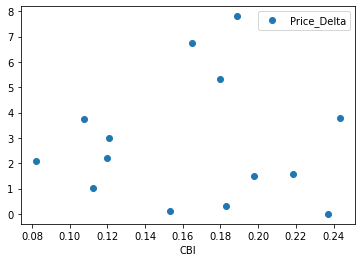

In [4]:
url="https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
##START - only needed when  getting SSLVerificationError in local##
context = ssl._create_unverified_context()
response = request.urlopen(url, context=context)
html = response.read()
##END - only needed when  getting SSLVerificationError in local##
table=pd.read_html(html)
sp500 = table[0]
print (sp500)
sp500 = sp500[['Symbol','Security','GICS Sector']]
# sp500 = sp500.head(5)

# filename = 'constituents_csv.csv'
# sp500 = pd.read_csv(filename)
# sp500['CBI_RSI']= np.nan
sp500['CBI_SS']= np.nan
sp500['CBI_MACD']= np.nan
sp500['CBI'] = np.nan
sp500['t-30price'] = np.nan
sp500['Price_Delta'] = np.nan
sp500['Trade_Date'] = np.nan
sp500 = sp500[sp500['Symbol'] != "."]
# sp500 = sp500.head(100)

# sp500.groupby(['GICS Sector']).count()
# df2['CBI'] = CBI_func(df2['Symbol'],start_time,end_time)

# start_time = (datetime.datetime.now().date() - datetime.timedelta(days = 90)).isoformat()
# end_time = (datetime.datetime.now().date() - datetime.timedelta(days = 30)).isoformat()
print("Start Date: ", start_time)
print("End Date: ", end_time )

#
sector_list = list(sp500['GICS Sector'].unique())
sector_list = ['Information Technology']
#ticker_list = list(sp500['Symbol'])
passed_tickers=[]
no_data_tickers = []
for sector in sector_list:
    ticker_list = list(sp500[sp500['GICS Sector']==sector]['Symbol'])
    for ticker in ticker_list:
      for delta in range(1,30):
        try:
          CBIL = CBI_func(ticker, start_time, end_time,delta)

          if len(CBIL) > 0 and CBIL[5] < 0.25:
            sp500.loc[sp500['Symbol'] == ticker, ['Trade_Date','CBI_SS','CBI_MACD','CBI','t-30price','Price_Delta']] = [CBIL[0], CBIL[1], CBIL[2], CBIL[5],CBIL[3],CBIL[4]]
          
        except:
          print('Analyzed Security: ',ticker, 'No Data')
          no_data_tickers.append(ticker)
          continue


#print("CBI = ", CBI_all)
print(sp500)
print('Tickers Qualified by CBI Criteria: ', passed_tickers)
print('Tickers for which data was not obtained: ', no_data_tickers)
sp500.plot(x='CBI',y='Price_Delta',style='o')



------- QUALIFIED BY SS -----------
    Symbol                   Security             GICS Sector    CBI_SS  CBI_MACD       CBI   t-30price  Price_Delta           Trade_Date
6     ADBE                 Adobe Inc.  Information Technology  0.023610  0.371453  0.197532  444.299988     1.510246  2021-03-12 00:00:00
7      AMD     Advanced Micro Devices  Information Technology  0.053966  0.109944  0.081955   81.050003     2.097467  2021-03-12 00:00:00
45    AAPL                 Apple Inc.  Information Technology  0.000564  0.214277  0.107420  121.029999     3.751137  2021-03-12 00:00:00
81    CDNS     Cadence Design Systems  Information Technology  0.015904  0.458051  0.236977  129.389999     0.000000  2021-03-16 00:00:00
167   ENPH             Enphase Energy  Information Technology  0.104445  0.255105  0.179775  165.339996     5.334467  2021-03-11 00:00:00
267   JNPR           Juniper Networks  Information Technology  0.116059  0.261853  0.188956   23.959999     7.804678  2021-03-08 00:00

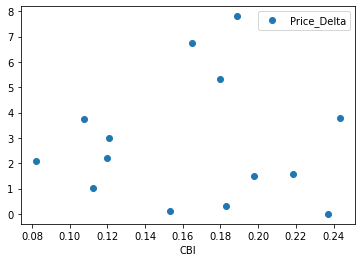

In [5]:
# print("\n\n------- QUALIFIED BY RSI -----------")
# print(sp500[sp500['CBI_RSI'] < 0.25])
sp500.plot(x='CBI',y='Price_Delta',style='o')
sp500.to_csv('Output.csv')

print("\n\n------- QUALIFIED BY SS -----------")
print(sp500[sp500['CBI_SS'] < 0.25])

print("\n\n------- QUALIFIED BY MACD -----------")
print(sp500[sp500['CBI_MACD'] < 0.25])

print("\n\n------- QUALIFIED BY CBI -----------")
print(sp500[sp500['CBI'] < 0.25])
